<a href="https://colab.research.google.com/github/sruthi2498/Arduino-based-smart-glove/blob/master/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import pandas as pd
import string
import json
import requests
import numpy as np

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers, Model
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, SpatialDropout1D, LSTM, Bidirectional, TimeDistributed, Input
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils.vis_utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

In [3]:
url = "https://raw.githubusercontent.com/paresh-nayyar/CSCI-544_NLP/master/data/Towards_Emotion_Recognition_text%26emotions.csv?token=GHSAT0AAAAAABQE6M6KU545Y63IPZNPX34OYSXJ4EQ"
df = pd.read_csv(url)
df.head()

HTTPError: ignored

In [4]:
train_url = "https://raw.githubusercontent.com/paresh-nayyar/CSCI-544_NLP/master/data/TER_text%26emotions_train.csv?token=GHSAT0AAAAAABQE6M6LBWXFXY4RATXWVQOYYS54ZOQ"
test_url = "https://raw.githubusercontent.com/paresh-nayyar/CSCI-544_NLP/master/data/TER_text%26emotions_test.csv?token=GHSAT0AAAAAABQE6M6KMHW27U6UHRW3KQRIYS54ZQA"
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)
len(train_df),len(test_df)


(107754, 26939)

In [5]:
train_df.head()

,tweet_id,tweet,anger,disgust,fear,happiness,sadness,surprise,cleaned_tweet,cleaned_tweet_tokens
0,372412154051170304,bsppsb kya scary cha hai,0,0,1,0,0,0,bsppsb kya scary cha hai,"['bsppsb', 'kya', 'scary', 'cha', 'hai']"
1,1066362251538558976,urstrulymahesh thumsupofficial such an amazing...,0,0,0,0,0,1,urstrulymahesh thumsupofficial such an amazing...,"['urstrulymahesh', 'thumsupofficial', 'such', ..."
2,15364902520627200,mujhe in pathron ka darr na hota agr dil me sh...,0,0,1,0,0,0,mujhe in pathron ka darr na hota agr dil me sh...,"['mujhe', 'in', 'pathron', 'ka', 'darr', 'na',..."
3,441535551506624512,mukhang ewan gross huehue httptcoet2dwibe6h,0,1,0,0,0,0,mukhang ewan gross huehue httptcoet2dwibe6h,"['mukhang', 'ewan', 'gross', 'huehue', 'httptc..."
4,593300371050668034,hathwalathakur chup kar be bhosdike teri green...,1,0,0,0,0,0,hathwalathakur chup kar be bhosdike teri green...,"['hathwalathakur', 'chup', 'kar', 'be', 'bhosd..."


In [6]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


In [7]:
%cd drive/My Drive/
# !ls

/content/drive/My Drive


In [8]:
from gensim.models import FastText
fasttext_url = "./fasttext_model/fasttext_model.model"
embeddings_index = FastText.load(fasttext_url)

In [9]:
label_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
y_train = train_df[label_names].values
y_test = test_df[label_names].values

train_df['doc_len'] = train_df['tweet'].astype(str).apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
#max_seq_len = train_df['doc_len'].max()
print(max_seq_len)


28


In [10]:
processed_docs_train = train_df['tweet'].astype(str).tolist()
processed_docs_test = test_df['tweet'].astype(str).tolist() 
num_classes = len(label_names)

In [11]:
MAX_NB_WORDS = 200000
tokenizer = RegexpTokenizer(r'\w+')

In [12]:
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
total_docs=[]
total_docs.extend(processed_docs_train)
total_docs.extend(processed_docs_test)
#tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
tokenizer.fit_on_texts(total_docs)
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
#print(word_seq_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print(len(word_index))
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
print(word_seq_train[2])
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

tokenizing input data...
235929
dictionary size:  235929
[   59    92 10454     8    26    13    56   618    53    14  9069     8
   144    13    56 34369    45   405 72835  3975   618    53    10  6391
     8    26    13    56]


In [13]:
#training params
batch_size = 64
num_epochs = 8 

#model parameters
num_filters = 128 
num_kernels=200
stride=1
embed_dim = 300
weight_decay = 1e-4

#parallel layers 
kernel_size=7
kernel_size_p1=3
kernel_size_p2=6
kernel_size_p3=9
kernel_size_p4=12

In [14]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    #print(word)

    if embeddings_index.wv.__contains__(word): 

        embedding_vector = embeddings_index.wv[word]
    
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
#print(embedding_matrix)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [15]:
print(len(embedding_matrix[34]))
print(words_not_found)


300
[]


In [24]:
def getCNNModel():
  model = Sequential()
  model.add(Embedding(nb_words, embed_dim,
            weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
  model.add(Conv1D(num_kernels, kernel_size, activation='relu', padding='same'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(num_kernels, kernel_size, activation='relu', padding='same'))
  #model.add(GlobalMaxPooling1D())
  model.add(MaxPooling1D(2))
  #model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  #model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)
  model.add(Dense(num_classes, activation='softmax')) 

  # adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # model.summary()
  return model

model = getCNNModel()

In [20]:
import matplotlib.pyplot as plt
def plotAcc(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def plotLoss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


Epoch 1/8
1516/1516 [==============================] - 305s 201ms/step - loss: 0.2414 - accuracy: 0.9204 - val_loss: 0.1372 - val_accuracy: 0.9547
Epoch 2/8
1516/1516 [==============================] - 296s 195ms/step - loss: 0.1346 - accuracy: 0.9579 - val_loss: 0.1323 - val_accuracy: 0.9573
Epoch 3/8
1516/1516 [==============================] - 302s 199ms/step - loss: 0.1200 - accuracy: 0.9625 - val_loss: 0.1209 - val_accuracy: 0.9616
Epoch 4/8
1516/1516 [==============================] - 265s 175ms/step - loss: 0.1087 - accuracy: 0.9658 - val_loss: 0.1201 - val_accuracy: 0.9607
Epoch 5/8
1516/1516 [==============================] - 289s 190ms/step - loss: 0.1037 - accuracy: 0.9668 - val_loss: 0.1138 - val_accuracy: 0.9636
Epoch 6/8
1516/1516 [==============================] - 303s 200ms/step - loss: 0.0982 - accuracy: 0.9688 - val_loss: 0.1158 - val_accuracy: 0.9635
Epoch 7/8
1516/1516 [==============================] - 278s 183ms/step - loss: 0.0915 - accuracy: 0.9704 - val_loss: 0

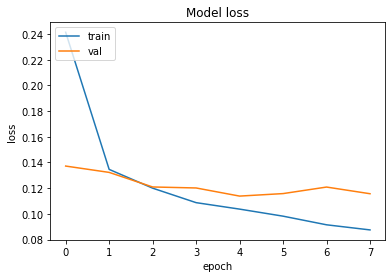

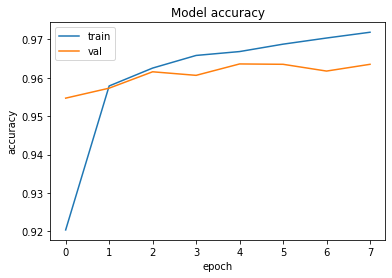

In [21]:
history = model.fit(word_seq_train, y_train, batch_size=batch_size, 
                    epochs=num_epochs, validation_split=0.1, shuffle=True, verbose = 1)
plotLoss(history)
plotAcc(history)

In [ ]:
model = getCNNModel()
best_epochs = np.argmin(history.history["val_loss"])+1
model.fit(word_seq_train, y_train, batch_size=batch_size, 
                    epochs=best_epochs, shuffle=True, verbose = 1)

Epoch 1/5
1684/1684 [==============================] - 303s 179ms/step - loss: 0.2368 - accuracy: 0.9211
Epoch 2/5
1684/1684 [==============================] - 286s 170ms/step - loss: 0.1357 - accuracy: 0.9579
Epoch 3/5
 429/1684 [======>.......................] - ETA: 3:23 - loss: 0.1226 - accuracy: 0.9603

In [ ]:
def accuracy(model,test,y_test):
  predictions = model.predict(test)
  pred_labels = np.argmax(predictions, axis=1)
  y_test_labels = [np.where(x==1)[0][0] for x in y_test]
  print(np.sum(y_test_labels == pred_labels)/len(pred_labels))
